In [1]:
# Import from gridfm-datakit to access process_network functions
# ## datakit should be in opf branch ##
import sys
import os
sys.path.insert(0, os.path.abspath('../../gridfm-datakit')) #Replace with the correct path
sys.path.append(os.path.abspath('../../gridfm-graphkit')) #Replace with the correct path
from gridfm_datakit.process.process_network import (
    network_preprocessing,
    pf_preprocessing,
    pf_post_processing,
)
from gridfm_datakit.process.solvers import run_pf, run_opf
from gridfm_datakit.save import save_node_edge_data

from gridfm_graphkit.datasets.powergrid_datamodule import LitGridDataModule
from gridfm_graphkit.io.param_handler import NestedNamespace
from gridfm_graphkit.tasks.feature_reconstruction_task import FeatureReconstructionTask
from gridfm_graphkit.utils.visualization import (
    visualize_error,
    visualize_quantity_heatmap,
)
from gridfm_graphkit.datasets.globals import PD, QD, PG, QG, VM, VA


In [2]:
# DEMONSTRATE GRIDSEARCH WITH CASE14
# https://dwightreid.com/site/power-system-contingency-analysis-with-python-pandapower/

import pandas as pd
import pandapower as pp
import pandapower.networks as ppnets
import pandapower.plotting as plt
import pandapower.plotting.plotly as pplotly
import matplotlib.pyplot as mplt

In [3]:
net =  ppnets.case14() 
# net.ext_grid['in_service']=False # disconnect from external grid - create an island
print(net.ext_grid['in_service'])
print(net.gen.loc[3,'slack'])
net

0    True
Name: in_service, dtype: bool
False


This pandapower network includes the following parameter tables:
   - bus (14 elements)
   - load (11 elements)
   - gen (4 elements)
   - shunt (1 element)
   - ext_grid (1 element)
   - line (15 elements)
   - trafo (5 elements)
   - poly_cost (5 elements)
   - bus_geodata (14 elements)

In [4]:
net.bus

,name,vn_kv,type,zone,in_service,max_vm_pu,min_vm_pu
0,1,135.000,b,1.0,True,1.06,0.94
1,2,135.000,b,1.0,True,1.06,0.94
2,3,135.000,b,1.0,True,1.06,0.94
3,4,135.000,b,1.0,True,1.06,0.94
4,5,135.000,b,1.0,True,1.06,0.94
5,6,0.208,b,1.0,True,1.06,0.94
6,7,14.000,b,1.0,True,1.06,0.94
7,8,12.000,b,1.0,True,1.06,0.94
8,9,0.208,b,1.0,True,1.06,0.94
9,10,0.208,b,1.0,True,1.06,0.94


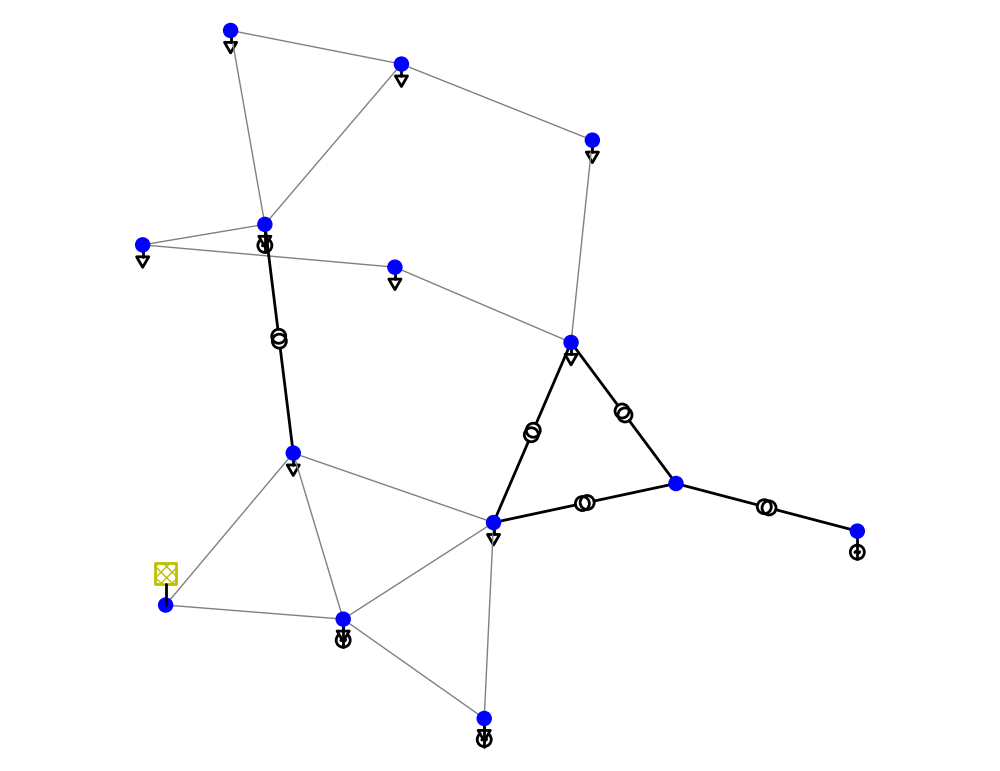

<Axes: >

In [5]:
plt.simple_plot(net,  plot_loads=True, plot_gens=True)

In [6]:
# net.gen['vm_pu']=1.045

# Perform a generator dispatch by maxing out the first three generators and setting the fourth one as the slack.
# net.gen.loc[0,'p_mw'] = 140 #1
# net.gen.loc[1,'p_mw'] = 100 #2
# net.gen.loc[2,'p_mw'] = 100 #5
# net.gen.loc[3,'slack'] = True #7

In [7]:
net.gen

,name,bus,p_mw,vm_pu,sn_mva,min_q_mvar,max_q_mvar,scaling,slack,in_service,slack_weight,type,controllable,max_p_mw,min_p_mw
0,None,1,40.0,1.045,NaN,-40.0,50.0,1.0,False,True,0.0,None,True,140.0,0.0
1,None,2,0.0,1.010,NaN,0.0,40.0,1.0,False,True,0.0,None,True,100.0,0.0
2,None,5,0.0,1.070,NaN,-6.0,24.0,1.0,False,True,0.0,None,True,100.0,0.0
3,None,7,0.0,1.090,NaN,-6.0,24.0,1.0,False,True,0.0,None,True,100.0,0.0


In [8]:
net.load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type,controllable
0,None,1,21.7,12.7,0.0,0.0,NaN,1.0,True,None,False
1,None,2,94.2,19.0,0.0,0.0,NaN,1.0,True,None,False
2,None,3,47.8,-3.9,0.0,0.0,NaN,1.0,True,None,False
3,None,4,7.6,1.6,0.0,0.0,NaN,1.0,True,None,False
4,None,5,11.2,7.5,0.0,0.0,NaN,1.0,True,None,False
5,None,8,29.5,16.6,0.0,0.0,NaN,1.0,True,None,False
6,None,9,9.0,5.8,0.0,0.0,NaN,1.0,True,None,False
7,None,10,3.5,1.8,0.0,0.0,NaN,1.0,True,None,False
8,None,11,6.1,1.6,0.0,0.0,NaN,1.0,True,None,False
9,None,12,13.5,5.8,0.0,0.0,NaN,1.0,True,None,False


In [9]:
pp.runpp(net,numba=False)
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.060000,0.000000,-232.393272,16.549301
1,1.045000,-4.982589,-18.300000,-30.857100
2,1.010000,-12.725100,94.200000,-6.075348
3,1.017671,-10.312901,47.800000,-3.900000
4,1.019514,-8.773854,7.600000,1.600000
5,1.070000,-14.220946,11.200000,-5.230944
6,1.061520,-13.359627,0.000000,0.000000
7,1.090000,-13.359627,0.000000,-17.623451
8,1.055932,-14.938521,29.500000,-4.584844
9,1.050985,-15.097288,9.000000,5.800000


In [10]:
# Real power: gen ?= load + shunt(consumption) + xward + losses + export
#P_rhs = P_load + max(P_shunt, 0.0) + P_xward + P_loss + P_export
#Q_rhs = Q_load + Q_loss + Q_shunt + Q_xward + Q_export

# the basic way
print('P_load = ' ,net.res_load['p_mw'].sum())
print('P_gen = ' ,net.res_gen['p_mw'].sum()+net.res_sgen['p_mw'].sum()+net.res_ext_grid['p_mw'].sum())
print('P_shunt = ',net.res_shunt['p_mw'].sum())
print('P_loss = ',net.res_line['pl_mw'].sum()+net.res_trafo['pl_mw'].sum())
print('***************************')
print('Q_load = ' ,net.res_load['q_mvar'].sum())
print('Q_gen = ' ,net.res_gen['q_mvar'].sum()+net.res_sgen['q_mvar'].sum()+net.res_ext_grid['q_mvar'].sum())
print('Q_shunt = ',net.res_shunt['q_mvar'].sum())
print('Q_loss = ',net.res_line['ql_mvar'].sum()+net.res_trafo['ql_mvar'].sum())

P_load =  259.0
P_gen =  272.3932723516124
P_shunt =  0.0
P_loss =  13.393272357163402
***************************
Q_load =  73.5
Q_gen =  82.43754385354322
Q_shunt =  -21.184844174429006
Q_loss =  30.12238804390666


Replace with gridfm finetuned model (case 14 now, later texas grid)
Best way to visualise the lo-voltages, high voltages and line overloading

In [12]:
from typing import Any


import pandapower as pp
import pandas as pd
import numpy as np


scenarios = pd.read_excel("../data/load-scenarios.xlsx")
# added_load_values = [0,5,10,15,20,25,30,35]
# added_load_values = [0,7,14,21,28,35]
added_load_values = [ 3.5, 10.5, 17.5, 24.5, 31.5, 38.5]
q_p_ratio = 0.5
vmax, vmin = 1.05, 0.95
line_loading_max = 1.0

lines = net.line.index
bus_to_load = {int(row.bus): idx for idx, row in net.load.iterrows()}

summary_records = [] #counts of violation per scenario, bus, added load
detail_records = [] #detailed records of violations per scenario, bus, added load, line dropped
processed_data = [] #processed data from pandapower




In [13]:

# LOOP 1: iterate over load scenarios
for i,scen_id in enumerate(scenarios['scenario'].unique()):
    scen_data = scenarios[scenarios['scenario'] == scen_id]
    print(f"\n=== Scenario {scen_id} ===")
    # set base case
    for _, row in scen_data.iterrows():
        bus = int(row['bus'])
        if bus in bus_to_load:
            load_idx = bus_to_load[bus]
            net.load.loc[load_idx, 'p_mw'] = row['p_mw']
            net.load.loc[load_idx, 'q_mvar'] = row['q_mvar']

    # LOOP 2: over buses
    for bus in scen_data['bus'].unique():
        if bus not in bus_to_load:
            continue
        load_idx = bus_to_load[bus]

        # LOOP 3: load increments
        for added_load in added_load_values:
            # Apply incremental load
            net.load.loc[load_idx, 'p_mw'] += added_load
            net.load.loc[load_idx, 'q_mvar'] += added_load * q_p_ratio

            run_opf(net)
            network_preprocessing(net) #imported from gridfm_datakit.process.process_network
            pf_preprocessing(net)

            # LOOP 4: contingency loop (line outages)
            for l in lines:
                net.line.loc[l, 'in_service'] = False
                try:
                    run_pf(net)
                    pf_data = pf_post_processing(net)
                        
                    processed_data.append((
                        pf_data['bus'],
                        pf_data['gen'],
                        pf_data['branch'],
                        pf_data['Y_bus'],
                    ))

                except pp.LoadflowNotConverged:
                    notConvergedCount += 1
                    net.line.loc[l, 'in_service'] = True
                    continue

                vm = net.res_bus.vm_pu
                line_loading = net.res_line.loading_percent / 100.0

                # restore line
                net.line.loc[l, 'in_service'] = True

            # Reset load to base value
            net.load.loc[load_idx, 'p_mw'] -= added_load
            net.load.loc[load_idx, 'q_mvar'] -= added_load * q_p_ratio




gen vm_pu > bus max_vm_pu for gens [2 3]. Setting bus limit for these gens.



=== Scenario 0 ===

=== Scenario 1 ===

=== Scenario 2 ===

=== Scenario 3 ===

=== Scenario 4 ===

=== Scenario 5 ===

=== Scenario 6 ===

=== Scenario 7 ===

=== Scenario 8 ===

=== Scenario 9 ===

=== Scenario 10 ===

=== Scenario 11 ===

=== Scenario 12 ===

=== Scenario 13 ===

=== Scenario 14 ===

=== Scenario 15 ===

=== Scenario 16 ===

=== Scenario 17 ===

=== Scenario 18 ===

=== Scenario 19 ===

=== Scenario 20 ===

=== Scenario 21 ===

=== Scenario 22 ===

=== Scenario 23 ===


In [14]:
#verification
print(len(processed_data))
print(24*6*15*11)
#15 lines, 11 buses, 24 scenarios, 6 added loads = 

23760
23760


In [15]:
%%writefile ./case14_finetune.yaml

seed: 42
data:
  networks: ["case14"]
  scenarios: [600000]
  normalization: "baseMVAnorm"
  baseMVA: 100
  mask_type: "pf"
  mask_value: 0.0
  mask_ratio: 0.5
  mask_dim: 6
  learn_mask: False
  val_ratio: 0.0
  test_ratio: 1.0
  workers: 16
model:
  attention_head: 8
  dropout: 0.1
  edge_dim: 2
  hidden_size: 256
  input_dim: 9
  num_layers: 8
  output_dim: 6
  pe_dim: 20
  type: GPSTransformer
training:
  batch_size: 32
  epochs: 50
  losses: ["MaskedMSE", "PBE"]
  loss_weights: [0.9, 0.1]
  accelerator: auto
  devices: auto
  strategy: auto
optimizer:
  learning_rate: 0.0001
  beta1: 0.9
  beta2: 0.999
  lr_decay: 0.7
  lr_patience: 10
callbacks:
  patience: 20
  tol: 0


Overwriting ./case14_finetune.yaml


In [16]:
import os
dir_path = "/Users/srihi/Study/RA/gridfm-datakit/data_test/case14/raw/" #network name here should match the network name in the yaml file
os.makedirs(dir_path, exist_ok=True)

#clear raw folder contents if they exist
if os.path.exists(dir_path):
    for file in os.listdir(dir_path):
        os.remove(os.path.join(dir_path, file))


save_node_edge_data(
    net=net,  # The network object
    node_path=dir_path+"pf_node.csv",     # Path for bus/node data
    branch_path=dir_path+"pf_edge_backup.csv",   # Path for branch/edge data
    gen_path=dir_path+"pf_gen.csv",       # Path for generator data
    y_bus_path=dir_path+"pf_edge.csv",    # Path for Y-bus data
    processed_data=processed_data,  # Your list of tuples
    dcpf=False  # Set to True if you want DC power flow columns
)


Paste the 4 files generated above into the data_test folder, and run the below code to get predictions

Modify the path of data_test as needed

In [17]:
import sys
import os
sys.path.append(os.path.abspath('../../gridfm-graphkit')) #Replace with the correct path
import torch
import lightning as L
import yaml
import numpy as np
import pandas as pd
import random
from gridfm_graphkit.io.param_handler import NestedNamespace
from gridfm_graphkit.datasets.powergrid_datamodule import LitGridDataModule
from gridfm_graphkit.tasks.feature_reconstruction_task import FeatureReconstructionTask

config_path = "./case14_finetune.yaml"

model_path = "../models/best_model_seawulf1.pt" #Replace with the correct path for the finetuned model
data_path = "../../gridfm-datakit/data_test"
output_path = data_path+"/predictions"
os.makedirs(output_path, exist_ok=True)
if os.path.exists(output_path):
    for file in os.listdir(output_path):
        os.remove(os.path.join(output_path, file))

# Load config
with open(config_path, "r") as f:
    config_dict = yaml.safe_load(f)
config_args = NestedNamespace(**config_dict)
torch.manual_seed(config_args.seed)
random.seed(config_args.seed)
np.random.seed(config_args.seed)

litGrid = LitGridDataModule(config_args, data_path)
litGrid.setup("test")

model = FeatureReconstructionTask(
    config_args,
    litGrid.node_normalizers,
    litGrid.edge_normalizers,
)

print(f"Loading model weights from {model_path}")
state_dict = torch.load(model_path, map_location='cpu')
model.load_state_dict(state_dict)

trainer = L.Trainer(
    accelerator='cpu',
    devices=1,
    logger=False,  
)

predictions = trainer.predict(model=model, datamodule=litGrid)

all_outputs = []
all_scenarios = []
all_bus_numbers = []

for batch in predictions:
    all_outputs.append(batch["output"])
    all_scenarios.append(batch["scenario_id"])
    all_bus_numbers.append(batch["bus_number"])

outputs = np.concatenate(all_outputs, axis=0)
scenario_ids = np.concatenate(all_scenarios, axis=0)
bus_numbers = np.concatenate(all_bus_numbers, axis=0)

predictions_df = pd.DataFrame({
    "scenario": scenario_ids,
    "bus": bus_numbers,
    "PD_pred": outputs[:, 0],
    "QD_pred": outputs[:, 1],
    "PG_pred": outputs[:, 2],
    "QG_pred": outputs[:, 3],
    "VM_pred": outputs[:, 4],
    "VA_pred": outputs[:, 5],
})


Processing...


BaseMVA set to: 221.0938262939453
---> BaseMVA: 221.0938262939453


100%|██████████| 23760/23760 [00:22<00:00, 1048.36it/s]
Done!
/Users/srihi/Study/RA/gridfm-graphkit/gridfm_graphkit/datasets/powergrid_datamodule.py:136: UserWarning: Requested number of scenarios (600000) exceeds dataset size (23760). Using the full dataset instead.
  warnings.warn(
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


BaseMVA set to: 221.0938262939453
BaseMVA set to: 221.0938262939453
Loading model weights from ../models/best_model_seawulf1.pt
Setup already done for stage=predict, skipping...


/Users/srihi/miniconda3/envs/gridfm/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/srihi/miniconda3/envs/gridfm/lib/python3.10/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 11 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/Users/srihi/miniconda3/envs/gridfm/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
/Users/srihi/miniconda3/envs/gridfm/lib/python3.10/s

Predicting: |          | 0/? [00:00<?, ?it/s]

In [18]:
predictions_df_original = predictions_df.copy()

In [19]:
dir_path = "/Users/srihi/Study/RA/gridfm-datakit/data_test/case14/raw/"
# Save predictions
os.makedirs(output_path, exist_ok=True)
csv_path_pred = os.path.join(output_path, "predictions.csv")
predictions_df = predictions_df.sort_values(["scenario", "bus"]).reset_index(drop=True)

pf_node = pd.read_csv(dir_path+"pf_node.csv")
pv_ref_info = (
    pf_node[["scenario", "bus", "PV", "REF", "Vm"]]
    .rename(columns={"Vm": "Vm_actual"})
)
predictions_df = predictions_df.merge(pv_ref_info, on=["scenario", "bus"], how="left")

pv_ref_mask = (predictions_df["PV"] == 1) | (predictions_df["REF"] == 1)
predictions_df.loc[pv_ref_mask, "VM_pred"] = predictions_df.loc[pv_ref_mask, "Vm_actual"]
predictions_df = predictions_df.drop(columns=["PV", "REF", "Vm_actual"])
predictions_df.to_csv(csv_path_pred, index=False)

print(f"Saved predictions to {csv_path_pred}")
print(f"Predictions shape: {predictions_df.shape}")

/var/folders/zg/fw0xg8nx6jv62p4n1frlcb_80000gn/T/ipykernel_59139/1884860334.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.06       1.04059177 1.01587621 ... 1.03276513 1.06       1.06      ]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  predictions_df.loc[pv_ref_mask, "VM_pred"] = predictions_df.loc[pv_ref_mask, "Vm_actual"]


Saved predictions to ../../gridfm-datakit/data_test/predictions/predictions.csv
Predictions shape: (332640, 8)


Compare the predicted values with the actual values from pf_node.csv

Distribution of train and test data is not same

In [20]:
print(outputs.shape)
print(litGrid.node_normalizers[0].baseMVA)
print(litGrid.edge_normalizers[0].baseMVA)

(332640, 6)
tensor(221.0938)
tensor(221.0938)



=== Error Summary (Load Buses Only) ===

VM Error Statistics:
count    332640.000000
mean          0.000503
std           0.001676
min           0.000000
25%           0.000000
50%           0.000163
75%           0.000564
max           0.245130
Name: VM_error, dtype: float64


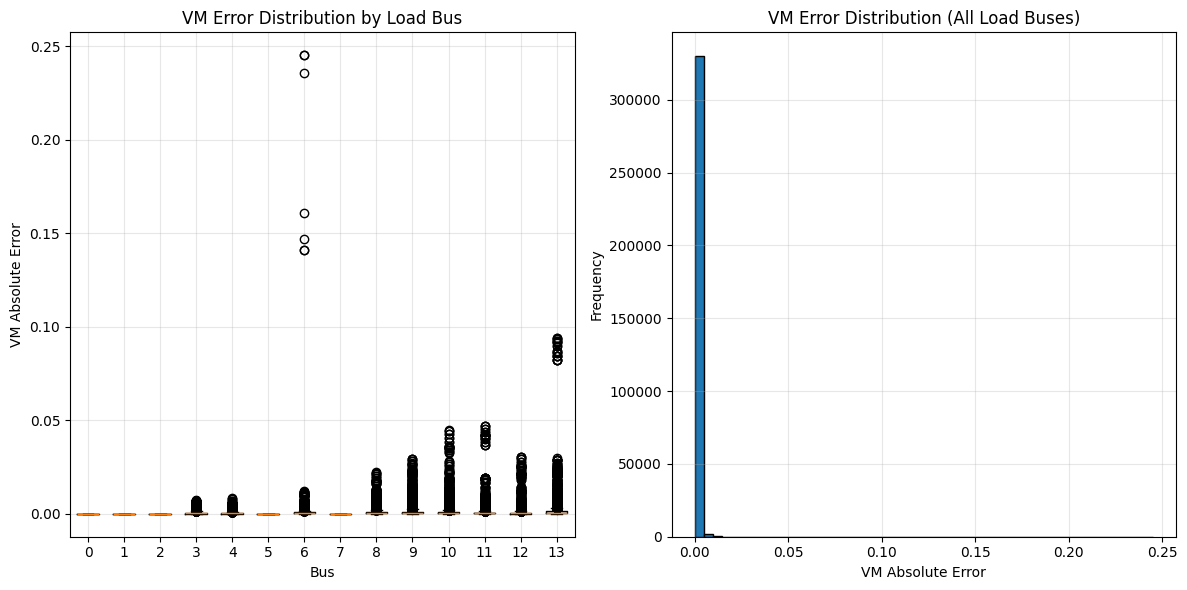

In [21]:
#PLOT THE ERRORS between actual and predicted values
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


pf_node = pd.read_csv(dir_path+"pf_node.csv")
predictions = pd.read_csv(csv_path_pred)

# gen_buses = [0, 1, 2, 5, 7] 
# load_buses = [b for b in pf_node['bus'].unique() if b not in gen_buses]
load_buses = [b for b in pf_node['bus'].unique()]

# Merge the dataframes
comparison = pf_node.merge(predictions, on=['scenario', 'bus'], how='inner')

comparison = comparison[comparison['bus'].isin(load_buses)]

comparison['VM_error'] = abs(comparison['Vm'] - comparison['VM_pred'])
comparison['VA_error'] = abs(comparison['Va'] - comparison['VA_pred'])
comparison['PD_error'] = abs(comparison['Pd'] - comparison['PD_pred'])
comparison['QD_error'] = abs(comparison['Qd'] - comparison['QD_pred'])

# Summary statistics
print("\n=== Error Summary (Load Buses Only) ===")
print(f"\nVM Error Statistics:")
print(comparison['VM_error'].describe())

# Optional: Plot VM errors
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for bus in load_buses:
    bus_data = comparison[comparison['bus'] == bus]['VM_error']
    plt.boxplot(bus_data, positions=[bus], widths=0.6)
plt.xlabel('Bus')
plt.ylabel('VM Absolute Error')
plt.title('VM Error Distribution by Load Bus')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(comparison['VM_error'], bins=50, edgecolor='black')
plt.xlabel('VM Absolute Error')
plt.ylabel('Frequency')
plt.title('VM Error Distribution (All Load Buses)')
plt.grid(True, alpha=0.3)

plt.tight_layout()


BELOW CODE NOT USED, JUST PUT FOR REFERENCE

Compare violations between predicted and actual values

In [ ]:
# import pandas as pd
# import numpy as np

# # Read data
# # pf_edge = pd.read_csv(dir_path+"/pf_edge.csv")
# pf_node = pd.read_csv(dir_path+"/pf_node.csv")
# predictions = pd.read_csv("../data/case14_ieee/predictions/predictions.csv")

# # Parameters
# vmax, vmin = 1.05, 0.95
# line_loading_max = 1.0
# gen_buses = [1, 2, 5, 7]  # Removed 0

# print(f"Unique scenarios in predictions: {predictions['scenario'].nunique()}")

# # Get scenarios that exist in BOTH files
# common_scenarios = sorted(set(pf_node['scenario'].unique()) & set(predictions['scenario'].unique()))


# # Analyze Pandapower results for COMMON scenarios only
# pp_violations = []
# for scenario in common_scenarios:
#     scenario_buses = pf_node[pf_node['scenario'] == scenario]
#     # scenario_lines = pf_edge[pf_edge['scenario'] == scenario]
    
#     # Only check voltage on load buses
#     load_buses = scenario_buses[~scenario_buses['bus'].isin(gen_buses)]
#     vm = load_buses['Vm'].values
    
#     # Count voltage violations
#     lv_count = np.sum(vm < vmin)
#     hv_count = np.sum(vm > vmax)
    
#     # Count line overloading
#     # in_service = scenario_lines['br_status'] == 1.0
#     # active_lines = scenario_lines[in_service]
    
#     pp_violations.append({
#         'scenario': scenario,
#         'pp_lv_count': lv_count,
#         'pp_hv_count': hv_count
#     })

# pp_violations_df = pd.DataFrame(pp_violations)

# # Analyze GridFM predictions for COMMON scenarios only
# gf_violations = []
# for scenario in common_scenarios:
#     scenario_data = predictions[predictions['scenario'] == scenario]
    
#     # Only check voltage on load buses
#     load_data = scenario_data[~scenario_data['bus'].isin(gen_buses)]
#     vm_pred = load_data['VM_pred'].values
    
#     # Count voltage violations
#     lv_count = np.sum(vm_pred < vmin)
#     hv_count = np.sum(vm_pred > vmax)
    
#     gf_violations.append({
#         'scenario': scenario,
#         'gf_lv_count': lv_count,
#         'gf_hv_count': hv_count,
#     })

# gf_violations_df = pd.DataFrame(gf_violations)

# # Merge and compare
# comparison = pp_violations_df.merge(gf_violations_df, on='scenario', how='inner')
# comparison['lv_mismatch'] = comparison['pp_lv_count'] != comparison['gf_lv_count']
# comparison['hv_mismatch'] = comparison['pp_hv_count'] != comparison['gf_hv_count']

# # Get scenarios with mismatches
# mismatch_mask = comparison['lv_mismatch'] | comparison['hv_mismatch']
# mismatched_scenarios = comparison[mismatch_mask]['scenario'].tolist()

# # Print violation details for ALL mismatched scenarios
# print("\n=== Investigating Violations in Mismatched Scenarios ===\n")

# violation_details = []

# for scenario in mismatched_scenarios:
#     pp_data = pf_node[pf_node['scenario'] == scenario]
#     gf_data = predictions[predictions['scenario'] == scenario]
    
#     # Filter load buses only
#     pp_load = pp_data[~pp_data['bus'].isin(gen_buses)]
#     gf_load = gf_data[~gf_data['bus'].isin(gen_buses)]
    
#     # Find low voltage buses in Pandapower
#     pp_lv_mask = pp_load['Vm'] < vmin
#     pp_hv_mask = pp_load['Vm'] > vmax
    
#     # Check for violations
#     if pp_lv_mask.any():
#         print(f"--- Scenario {scenario}: LOW VOLTAGE violations ---")
#         for _, row in pp_load[pp_lv_mask].iterrows():
#             bus = row['bus']
#             pp_vm = row['Vm']
#             gf_row = gf_load[gf_load['bus'] == bus]
#             if len(gf_row) > 0:
#                 gf_vm = gf_row.iloc[0]['VM_pred']
#                 error = pp_vm - gf_vm
#                 print(f"  Bus {bus}: PP_VM={pp_vm:.6f}, GF_VM={gf_vm:.6f}, Error={error:.6f}")
#                 violation_details.append({
#                     'scenario': scenario,
#                     'bus': bus,
#                     'violation_type': 'LV',
#                     'pp_value': pp_vm,
#                     'gf_value': gf_vm,
#                     'error': error
#                 })
    
#     if pp_hv_mask.any():
#         print(f"--- Scenario {scenario}: HIGH VOLTAGE violations ---")
#         for _, row in pp_load[pp_hv_mask].iterrows():
#             bus = row['bus']
#             pp_vm = row['Vm']
#             gf_row = gf_load[gf_load['bus'] == bus]
#             if len(gf_row) > 0:
#                 gf_vm = gf_row.iloc[0]['VM_pred']
#                 error = pp_vm - gf_vm
#                 print(f"  Bus {bus}: PP_VM={pp_vm:.6f}, GF_VM={gf_vm:.6f}, Error={error:.6f}")
#                 violation_details.append({
#                     'scenario': scenario,
#                     'bus': bus,
#                     'violation_type': 'HV',
#                     'pp_value': pp_vm,
#                     'gf_value': gf_vm,
#                     'error': error
#                 })

# # Print summary statistics
# print("\n=== Summary Statistics ===")
# print(f"Scenarios with perfect agreement: {np.sum(~mismatch_mask)}")
# print(f"Scenarios with LV count mismatches: {comparison['lv_mismatch'].sum()}")
# print(f"Scenarios with HV count mismatches: {comparison['hv_mismatch'].sum()}")
# print(f"Percentage agreement (LV): {100*np.mean(~comparison['lv_mismatch']):.2f}%")
# print(f"Percentage agreement (HV): {100*np.mean(~comparison['hv_mismatch']):.2f}%")

# if violation_details:
#     violation_df = pd.DataFrame(violation_details)
#     print(f"\nMean error: {violation_df['error'].mean():.6f}")
#     print(f"Max error: {violation_df['error'].max():.6f}")
#     print(f"Min error: {violation_df['error'].min():.6f}")

In [ ]:
# import torch
# from torch_geometric.data import Data
# from gridfm_graphkit.models.gps_transformer import GPSTransformer
# import yaml

# config_path = "case14_finetune.yaml"
# model_path = "../../gridfm-graphkit/examples/models/GridFM_v0_2.pth"

# with open(config_path, "r") as f:
#     config_dict = yaml.safe_load(f)
# config_args = NestedNamespace(**config_dict)

# class SimpleModel(torch.nn.Module):
#     def __init__(self, config_args):
#         super().__init__()
#         self.model = GPSTransformer(config_args)
#         self.config = config_args
        
#     def forward(self, x, pe, edge_index, edge_attr, batch):
#         return self.model(x, pe, edge_index, edge_attr, batch)

# model = SimpleModel(config_args)
# state_dict = torch.load(model_path, map_location='cpu')
# model.load_state_dict(state_dict, strict=False)  # Use strict=False to ignore extra keys
# model.eval()

# # You'll also need normalizers - you'll need to load these from your data
# def denormalize_features(normalized_features, baseMVA=100):
#     """Simple denormalization assuming baseMVA normalization"""
#     denormed = normalized_features.copy()
#     # Power features are normalized by baseMVA
#     denormed[:, 0:4] *= baseMVA  # PD, QD, PG, QG
#     return denormed



# def run_gridfm_inference(pf_data, baseMVA=100):
#     """
#     Run GridFM inference on a single power flow case.
#     Reference Code: gridfm-graphkit/gridfm_graphkit/datasets/powergrid_dataset.py (line 140 - 174)
    
#     Args:
#         pf_data: Dictionary with keys 'bus', 'gen', 'branch', 'Y_bus'
#         baseMVA: Base MVA for denormalization
    
#     Returns:
#         Dictionary with predicted values
#     """
#     # Extract node features from bus data
#     # BUS_COLUMNS: bus, Pd, Qd, Pg, Qg, Vm, Va, PQ, PV, REF, vn_kv, min_vm_pu, max_vm_pu, GS, BS
#     bus_data = pf_data['bus']
    
#     # Node features: [Pd, Qd, Pg, Qg, Vm, Va, PQ, PV, REF] normalized
#     node_features = np.column_stack([
#         bus_data[:, 1] / baseMVA,  # Pd normalized
#         bus_data[:, 2] / baseMVA,  # Qd normalized
#         bus_data[:, 3] / baseMVA,  # Pg normalized
#         bus_data[:, 4] / baseMVA,  # Qg normalized
#         bus_data[:, 5],  # Vm (already in p.u.)
#         bus_data[:, 6] / 100,  # Va normalized (assume max 100 degrees)
#         bus_data[:, 7],  # PQ
#         bus_data[:, 8],  # PV
#         bus_data[:, 9],  # REF
#     ])
    

#     y_bus = pf_data['Y_bus']
#     edge_index = y_bus[:, 0:2].T.astype(int)  # [2, num_edges]
#     edge_attr = y_bus[:, 2:4] / baseMVA  # G, B normalized
    

#     edge_index_tensor = torch.tensor(edge_index, dtype=torch.long)
#     edge_attr_tensor = torch.tensor(edge_attr, dtype=torch.float32)
    
#     # PE
#     from gridfm_graphkit.datasets.transforms import AddNormalizedRandomWalkPE, AddEdgeWeights
#     from torch_geometric.data import Data

#     temp_data = Data(
#         edge_index=edge_index_tensor,
#         edge_attr=edge_attr_tensor,
#         num_nodes=len(bus_data)
#     )
    
#     pe_pre_transform = AddEdgeWeights() #PE?
#     temp_data = pe_pre_transform(temp_data) #PE?
#     pe_transform = AddNormalizedRandomWalkPE(walk_length=20, attr_name="pe") #PE?
#     temp_data = pe_transform(temp_data) #PE?
#     pe_tensor = temp_data.pe
    

#     x = torch.tensor(node_features, dtype=torch.float32)
#     batch = torch.zeros(len(bus_data), dtype=torch.long)
    
#     #inference
#     with torch.no_grad():
#         output = model(x, pe_tensor, edge_index_tensor, edge_attr_tensor, batch)
#         output_np = output.numpy()
    
#     # Denormalize
#     output_denorm = denormalize_features(output_np, baseMVA)
    
#     return {
#         'PD_pred': output_denorm[:, 0],
#         'QD_pred': output_denorm[:, 1],
#         'PG_pred': output_denorm[:, 2],
#         'QG_pred': output_denorm[:, 3],
#         'VM_pred': output_denorm[:, 4],
#         'VA_pred': output_denorm[:, 5] * 100,  # Convert back to degrees
#     }




In [ ]:
# print("net.res_bus\n",net.res_bus)
# print("net.res_line\n",net.res_line)
# print("net.res_trafo\n",net.res_trafo)
# print("net.res_load\n",net.res_load)
# print("net.res_gen\n",net.res_gen)
# print("net.res_ext_grid\n",net.res_ext_grid)

In [ ]:
#code snippet for not converged cases:
# record as special case
                    # detail_records.append({
                    #     'scenario': scen_id,
                    #     'bus': bus,
                    #     'added_load': added_load,
                    #     'line_dropped': l,
                    #     'lv_nodes': {},
                    #     'hv_nodes': {},
                    #     'overloaded_lines': {}
                    # })

# code snippet to record violations in 4th for loop:

# --- Check voltage limits ---
                # hv_nodes = {}
                # if vm.max() > vmax:
                #     hv_count += 1
                #     viol_buses = vm.index[vm > vmax]
                #     for vb in viol_buses:
                #         hv_nodes[int(vb)] = float(vm.loc[vb])

                # lv_nodes = {}
                # if vm.min() < vmin:
                #     lv_count += 1
                #     viol_buses = vm.index[vm < vmin]
                #     for vb in viol_buses:
                #         lv_nodes[int(vb)] = float(vm.loc[vb])

                # # --- Check line overload ---
                # overloaded_lines = {}
                # if line_loading.max() > line_loading_max:
                #     ol_count += 1
                #     viol_lines = line_loading.index[line_loading > line_loading_max]
                #     for vl in viol_lines:
                #         overloaded_lines[int(vl)] = float(line_loading.loc[vl])
                
                # Record details for EVERY case (violations or not)
                # detail_records.append({
                #     'scenario': scen_id,
                #     'bus': bus,
                #     'added_load': added_load,
                #     'line_dropped': l,
                #     'lv_nodes': lv_nodes,              # dict of {node_id: vm_pu}
                #     'hv_nodes': hv_nodes,              # dict of {node_id: vm_pu}
                #     'overloaded_lines': overloaded_lines  # dict of {line_id: loading}
                # })

#Add this in 3rd loop:
 # --- Store summary for this (scenario, bus, increment) ---
            # summary_records.append({
            #     'scenario': scen_id,
            #     'bus': bus,
            #     'added_load': added_load,
            #     'low_voltage': lv_count,
            #     'high_voltage': hv_count,
            #     'overloading': ol_count,

            # })

# ============================================================
# Final DataFrames
# ============================================================
# summary_df = pd.DataFrame(summary_records)
# details_df = pd.DataFrame(detail_records)

# print("\n=== Summary Results ===")
# print(summary_df.head())

# print("\n=== Detailed Violations ===")
# print(details_df.head()) 

In [ ]:
filtered_df = pf_node[pf_node['scenario'] == 7886][['scenario','bus','Vm','PQ','PV','REF']]
print(filtered_df)

In [ ]:
filtered_df_pred = predictions[predictions['scenario'] == 7886][['scenario','bus','VM_pred']]
print(filtered_df_pred)

In [ ]:
df_violations = pd.read_csv('/Users/srihi/Study/RA/violation_analysis/violation_comparison.csv')

In [ ]:
print(df_violations[df_violations['scenario_id'] == 4][df_violations['added_load']==0][df_violations['bus']==1]['hv_count_gt'])